In this tutorial we show how to use regpy as a low-level solver for VLBI problems.

In [9]:
#Load basic modules and setup logger
import numpy as np
import logging
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

import ehtim as eh

import pathlib 
current_path = str(pathlib.Path().absolute())

Load synthetic observations and exact solution

Loading uvfits:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring_eht2017_averaged.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mrbeam\mr_beam\examples/../synthetic_data/ring.fits


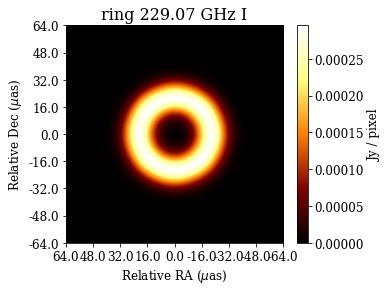

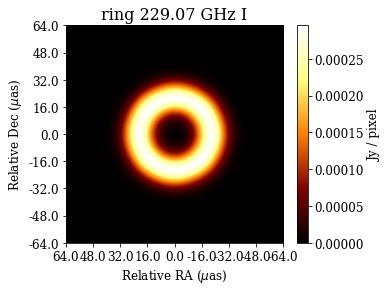

In [10]:
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2017_averaged.uvfits')
exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

imagingbase implements an interface between regpy and ehtim: EhtimWrapper

In [11]:
from imagingbase.ehtim_wrapper import EhtimWrapper
zbl = 0.6 #total compact flux
fov = exact_solution.fovx() #field of view, take the same one as in the exact solution
npix = exact_solution.xdim #number of pixels, take the same one as in the exact solution

prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (40*eh.RADPERUAS, 40*eh.RADPERUAS, 0, 0, 0))

wrapper = EhtimWrapper(obs_sc.copy(), prior.copy(), prior.copy(), zbl, clipfloor=-100)

Generating I image...


A functional (chi-squared) now can be defined by the EhtimFunctional option.

In [12]:
from imagingbase.ehtim_wrapper import EhtimFunctional
from MSI.Image import ConversionBase

#Find domain (grid) from the prior image
convert = ConversionBase()
grid = convert.find_domain_ehtim(prior)

#Define functional
func_vis = EhtimFunctional(wrapper, grid)

By default the chi-squared with respect to the visibilities will be computed. For other data terms, the 'd' option in the wrapper has to be changed. Let us define a final data fidelity term including the amplitudes, the closure phases and the closure amplitudes.

In [13]:
wrapper_amp = EhtimWrapper(obs_sc.copy(), prior.copy(), prior.copy(), zbl, clipfloor=-100, d='amp')
wrapper_cph = EhtimWrapper(obs_sc.copy(), prior.copy(), prior.copy(), zbl, clipfloor=-100, d='cphase')
wrapper_logcamp = EhtimWrapper(obs_sc.copy(), prior.copy(), prior.copy(), zbl, clipfloor=-100, d='logcamp')

func_amp = EhtimFunctional(wrapper_amp, grid)
func_cph = EhtimFunctional(wrapper_cph, grid)
func_logcamp = EhtimFunctional(wrapper_logcamp, grid)

data_fidelity = 0.2*func_amp + func_cph + func_logcamp

Generating I image...
Generating I image...
Generating I image...


In the same way we also could mimic the ehtim penalization terms. Let us use a total flux constraint only a define the penalization term.

In [14]:
wrapper_flux = EhtimWrapper(obs_sc.copy(), prior.copy(), prior.copy(), zbl, clipfloor=-100, d='flux')

penalty = EhtimFunctional(wrapper_flux, grid)

Generating I image...


We are solving the inverse problem now with the 'L-BFGS-B' algorithm from the scipy.optimize package through a regpy interface to scipy.optimize.

In [15]:
from imagingbase.solvers.scipy_solver import Minimize

options = {'maxiter' : 1000}

#total objective functional
func = data_fidelity + 1e4 * penalty

#we need flat input arrays for minimization
from regpy.operators import Reshape
from regpy.discrs import Discretization

func = func * Reshape(Discretization(npix*npix), grid)

#Define Minimization procedure
solver = Minimize(func, prior.imvec.copy(), method='L-BFGS-B', options=options)
solver.hess = None #explictly use no hessian matrix here

#run solver
reco = solver.run()

We can format the output to an ehtim Image object with the same properties (pixel size, frequency, ...) as the prior image by the formatoutput option. Then we display the result.

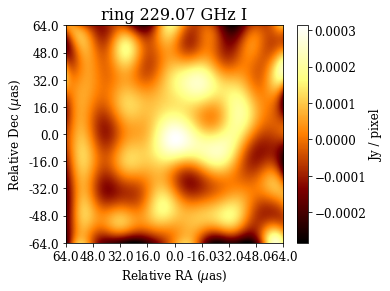

Final data fidelity term:  1.0826145279442487


In [8]:
out = wrapper.formatoutput(reco.reshape(npix, npix))
out.display()

#print score
print("Final data fidelity term: ", data_fidelity(out.imarr()))

While the final score indicates a very well (over-)fit (small chi_squareds), the reconstruction is still worse as now effective regularization was used. We will turn to the question of how to introduce effective regularization, especially by DoG-HiT, in the next tutorials.